# **Slumage**
**Jupyter notebook développé pour le pre-processing des images Sentinel-2 et Sentinel-1 pour les utiliser plus tard dans un modèle deep learning.** Ce notebook a été réalisé par Julien Govoorts dans le cardre d'un stage au sein de l'ANAGEO (IGEAT-ULB) pour le cours de STAG-F026 au sein du master en sciences et gestion de l'environnement à finalité sciences de l'environnement. Ce notebook utilise des données Sentinel-1 et 2 dans le but, dans un second temps, de cartographier (selon une probabilité) à partir d'un modèle deep learning les bidonvilles dans Nairobi (Kenya). 

Auteurs : Julien Govoorts et Taïs Grippa

## **Import libraries**

In [156]:
from osgeo import gdal
from osgeo import ogr
import os, sys
import numpy as np
import json
from sklearn.model_selection import train_test_split

In [157]:
import matplotlib.pyplot as plt
%matplotlib inline

In [158]:
import h5py

In [159]:
import numpy as np 
from cv2 import cvtColor, COLOR_BGR2RGB
	
def Norma_Xpercentile(image_data, prct:int = 2, BGR2RGB=True):
	'''
	Function that perform x percent histogram equalization of RGB images display
	'''

	a = np.ndarray(image_data.shape, dtype='float32')  
	a[:,:,0] = (image_data[:,:,0] - np.nanpercentile(image_data[:,:,0],prct))/(np.nanpercentile(image_data[:,:,0],100-prct) - np.nanpercentile(image_data[:,:,0],prct))
	a[:,:,1] = (image_data[:,:,1] - np.nanpercentile(image_data[:,:,1],prct))/(np.nanpercentile(image_data[:,:,1],100-prct) - np.nanpercentile(image_data[:,:,1],prct))
	a[:,:,2] = (image_data[:,:,2] - np.nanpercentile(image_data[:,:,2],prct))/(np.nanpercentile(image_data[:,:,2],100-prct) - np.nanpercentile(image_data[:,:,2],prct))
	if BGR2RGB: 
		a = cvtColor(a, COLOR_BGR2RGB)
	return a

## **Definition of functions**

### Function to extract coordinates from polygone shapefile

In [160]:
def extract_coord(output_poly): #fonction pour extraire les coordonnées géographiques à partir d'un fichier json
    
    extract_json = json.loads(output_poly) #convertion de l'input dans le format json
    coordinates = extract_json['coordinates'] #extraction des coordonnées
    #extraction des coordonnées nécessaire selon la structure des données json
    xmin = coordinates[0][0][0][0]
    xmax = coordinates[0][0][1][0]
    ymin = coordinates[0][0][0][1]
    ymax = coordinates[0][0][2][1]
    
    return xmin,ymin,xmax,ymax

### Function to merge multiple single band raster images to one raster multiplebands 

In [162]:
'''

This function automatically merge multiple rasters with a SINGLE band to a raster with multiple bands like RGB.
    Inputs :
        listRGBNIR : This input MUST be a list with the different SINGLE band raster that must be merged.
        output_dir : Is a string of the output directory. DO NOT FORGET to end the path with '/' Example : 'jgovoort/Images/S2/'
    Outputs :
        There is no output in Python. However, it will create a raster in GTiff format with all the merged bands in the indicate folder.
        
Contact : julien.govoorts@ulb.be

jgovoort

'''
def merge_RGBNIR(listRGBNIR,output_dir):
    gdal.BuildVRT("Images/RGBNIR.vrt",listRGBNIR, separate=True) #rassemble les 3 rasters à bande unique en un seul raster sous un format vrt
    output = output_dir+'merge_RGBNIR.tif'
    gdal.Translate(output_dir+'merge_RGBNIR'+'.tif',"Images/RGBNIR.vrt", format='GTiff') #traduit le format vrt en format GTiff
    
merge_RGBNIR(["Images/S2/S2_B04_2019_Q1_small.tif","Images/S2/S2_B03_2019_Q1_small.tif","Images/S2/S2_B02_2019_Q1_small.tif","Images/S2/S2_B08_2019_Q1_small.tif"],'Images/S2/')
    

### Function to normalise data
Coming from [here](https://github.com/tgrippa/Partimap/blob/cd72ecd2f3e32794eb3e0ee70399de1811b5399e/Notebooks/Data_preprocessing.ipynb)

In [163]:
#code from https://github.com/tgrippa/Partimap/blob/cd72ecd2f3e32794eb3e0ee70399de1811b5399e/Notebooks/Data_preprocessing.ipynb
def normalise_01(image_data):
    image_data -= np.min(stack, axis=0)
    image_data /= (np.max(stack, axis=0) - np.min(stack, axis=0))
    return image_data

### Function to divide the global image to multiple images (patch) of 10x10 

In [164]:
def chunckage(folder_raster,filename_raster,format_rast,folder_vector, filename_vector):
    
    rast = gdal.Open(folder_raster+filename_raster+format_rast) #ouverture du raster

    vector = ogr.Open(folder_vector+filename_vector) #ouverture de la fichier gkpg

    layer = vector.GetLayer() #extraction des couches dans le gkpg dans ce cas-ci il n'y en a qu'une seule (sinon spécifier)

    print(layer.GetExtent()) #affiche de l'emprise de la couche vectorielle
   
    os.system('mkdir ./'+folder_raster+filename_raster+'_patch') #création automatique de la directory pour enregistrer les patchs
    
    #étape d'initialisation de la boucle
    patch_id = [] #création des matrices
    patch_lulc = []
    listvrt = []

    for feat in layer: #une boucle sur les polygones dans la couche vectorielle
            polygone = feat.GetGeometryRef().ExportToJson() #extraire les données géométriques et exporter en format JSON
            list_coord = extract_coord(polygone) #extraction des coordonnées des polygones
            print(list_coord)
            poly_id = int(feat.GetField("id")) #extraire le id de l'object
            lulc = int(feat.GetField("lulc")) #extraire le lulc (si slum ou pas slum) de l'object
            name_file= filename_raster+'_'+str(poly_id)+'_'+str(lulc)+'.tif' #création du nom du fichier de sortie
            filename = folder_raster+filename_raster+'_patch/'+str(name_file)
            gdal.Warp(str(filename),rast, outputBounds = list_coord) #division en petite tuile correspondante aux polygone dans le shpfile
            listvrt.append(filename) #enregistremet dans une liste le chemin des patchs
            
            patch_id.append(poly_id) #enregistrement dans une liste l'id du patch
            patch_lulc.append(lulc) #enregistrement dans une liste si le patch est un slum ou pas

            
    return listvrt, patch_id, patch_lulc

## **Code**

### Creation of patchs and arraying its id and lulc

In [ ]:
merge_rbgnir_output = chunckage("Images/S2/","merge_RGBNIR",".tif",'Images/smaller/sample/','sample_grid.gpkg')
merge_rbgnir_list = merge_rbgnir_output[0] #inscrire dans une variable les path des patchs
patch_id_merge_rgbnir = merge_rbgnir_output[1] #inscrire dans une variable les id des patchs
patch_lulc_merge_rgbnir = merge_rbgnir_output[2] #inscrire dans une variable les lulc (slum ou pas) des patchs

patch_id_merge_rgbnir = np.array(patch_id_merge_rgbnir) #convertion en array
patch_lulc_merge_rgbnir = np.array(patch_lulc_merge_rgbnir)
patch_id_merge_rgbnir = patch_id_merge_rgbnir.reshape(patch_id_merge_rgbnir.size, -1) #on "transpose" l'array pour inverser ses dimensions
patch_lulc_merge_rgbnir = patch_lulc_merge_rgbnir.reshape(patch_lulc_merge_rgbnir.size, -1)

print(patch_id_merge_rgbnir)
print(patch_id_merge_rgbnir.dtype)

### Creation 4D Cube and normalisation of data

In [ ]:
#code inspired from https://github.com/tgrippa/Partimap/blob/cd72ecd2f3e32794eb3e0ee70399de1811b5399e/Notebooks/Data_preprocessing.ipynb
stack = []
for patch in merge_rbgnir_list :
    pat = gdal.Open(patch)
    data_rast = pat.ReadAsArray().astype(np.float32)
    data_rast = np.transpose(data_rast,(1,2,0))
    stack.append(data_rast)

stack= np.array(stack)
print(stack)
print(stack.shape)
print(stack.dtype)

stack = normalise_01(stack)



### Split of train patchs and test patchs

In [167]:
#séparation des patchs pour l'entrainement et la validation. 80% vont servir d'entraiment et 20% de valisdation (d'ou 0.2) avec seed = 10 (random_state)
patch_id_train, patch_id_test, patch_lulc_train, patch_lulc_test = train_test_split(patch_id_merge_rgbnir,patch_lulc_merge_rgbnir, test_size=0.2, random_state=10)

print(patch_id_train)
print(patch_lulc_train)

[[60896]
 [56286]
 [66185]
 ...
 [57823]
 [55270]
 [57581]]
[[0]
 [0]
 [0]
 ...
 [0]
 [1]
 [0]]


### Save database

In [168]:
data_path = 'Images/S2/merge_RGBNIR_patch/'
with h5py.File(os.path.join(data_path,"RGBNIR.hdf5"), mode="w") as f:
    f["id_train"] = patch_id_train               #enregistrement des id des patch qui vont servir à l'entrainement
    f["id_test"] = patch_id_test                 #enregistrement des id des patch qui vont servir à la validation
    f["lulc_train"] = patch_lulc_train           #enregistrement des lulc des patch qui vont servir à l'entrainement
    f["lulc_test"] = patch_lulc_test             #enregistrement des lulc des patch qui vont servir à la validation
    f["patch_id"] = patch_id_merge_rgbnir        #enregistrement de id des patchs
    f["patch_lulc"] = patch_lulc_merge_rgbnir    #enregistrement du lulc des patchs
    

print("Data exported in %s"%(data_path))

Data exported in Images/S2/merge_RGBNIR_patch/


## **Garbage test**

In [155]:
f = 0.854165841
print("my value = %.4f"%f)


my value = 0.8542


In [70]:
print(type(stack[4,9,9,0]))

<class 'numpy.float32'>


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


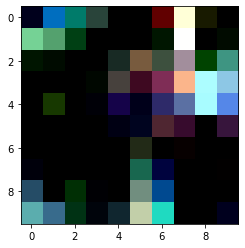

In [77]:
plt.imshow(Norma_Xpercentile(stack[0,:,:,]))

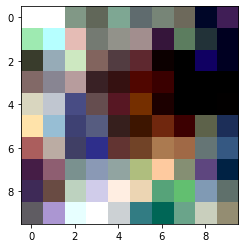

In [74]:
plt.imshow(Norma_Xpercentile(stack[5,:,:,]))

In [83]:
os.removedirs('/home/jgovoort/patch')

In [84]:
os.mkdir('./patch')

In [85]:
os.path.join('home','jgovoort','patch') 

'home/jgovoort/patch'

In [99]:
path = '/home/jgovoort/Images/Sentinel1.jpeg'
if os.path.splitext(path)[1] != '.tiff' or os.path.splitext(path)[1] != '.tif':
    sys.exit("NOT ALLOWED")

SystemExit: NOT ALLOWED

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3405: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [102]:
row = 'uygduhd,ddssdds,dsdsdsdsd,sddsszeez,dsdsd'
'|'.join(row.split(','))

'uygduhd|ddssdds|dsdsdsdsd|sddsszeez|dsdsd'